## Reproducing CVCL Fig.3 
### Generalization Evaluation

### Fig.3.A Generalization Class Accuracy
1. Run `main.py` for different seeds. (run `run.sh` directly)
2. After that, run following cells, they are doing:
    - Get average accuracy for each class in CVCL, plot boxplot
    - Get total accuracy in CVCL&CLIP, plot dashed line 

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

def load_data(files):
    data_list = []
    overall_acc = {'cvcl': [], 'clip': []}

    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
            model_type = 'clip' if 'clip' in data['args']['model'] else 'cvcl'
            overall_acc[model_type].append(data['overall_accuracy'])
            seed = data['args']['seed']
            if model_type == 'cvcl':
                
                data_list.extend({
                    'Category': category,
                    'Accuracy': accuracy,
                    'Seed': seed
                } for category, accuracy in data['class_accuracy'].items())
    
    return data_list, overall_acc

def prepare_dataframe(data_list):
    df = pd.DataFrame(data_list)
    df['Mean_Accuracy'] = df.groupby('Category')['Accuracy'].transform('mean')
    return df.sort_values(by='Mean_Accuracy', ascending=False)

In [3]:
# grep clip&cvcl results
files = glob.glob('/home/xke001/demo/zero-shot/results/trial_*_08-30_*.json')
df_class, overall_acc = load_data(files) 
df_class = prepare_dataframe(df_class)

In [4]:
# function to draw fig.3A
import matplotlib.ticker as mtick

def plt_class_acc(df_class, overall_acc, split_index):
    categories = df_class['Category'].unique()
    dfs = [df_class[df_class['Category'].isin(categories[:split_index])], 
           df_class[df_class['Category'].isin(categories[split_index:])]]

    fig, axs = plt.subplots(2, 1, figsize=(11, 7), sharey=True)
    fig.suptitle('Repro Results Using Provided Trial File', fontsize=18)
    meanpointprops = dict(marker='o', markeredgecolor='gray', markerfacecolor='Black', markersize=2.5)

    for i, df_part in enumerate(dfs):
        sns.boxplot(x='Category', y='Accuracy', data=df_part, ax=axs[i], color='silver',
                    fliersize=0, linewidth=1.5, showmeans=True, meanprops=meanpointprops)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)
        axs[i].set_ylabel('Accuracy (%)', fontsize=15)
        axs[i].set_xlabel('')
        axs[i].axhline(y=0.25, color='black', linestyle='--', linewidth=2.0)
        axs[i].axhline(y=overall_acc['cvcl'], color='green', linestyle='--', linewidth=2.0)
        axs[i].axhline(y=overall_acc['clip'], color='cornflowerblue', linestyle='--', linewidth=2.0)
        
        axs[i].text(len(df_part['Category'].unique()) + 0.1, overall_acc['cvcl'], f'CVCL {overall_acc["cvcl"]*100:.2f}%',
                    color='green', va='center', fontsize=12)
        axs[i].text(len(df_part['Category'].unique()) + 0.1, overall_acc['clip'], f'CLIP {overall_acc["clip"]*100:.2f}%',
                    color='cornflowerblue', va='center', fontsize=12)
        axs[i].text(len(df_part['Category'].unique()) + 0.1, 0.25, f'Baseline 25.00%',
                    color='Black', va='center', fontsize=12)
        
        axs[i].grid(True, linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
        axs[i].set_ylim(0, 1.02)
        axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_79066/3868747345.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)
/tmp/ipykernel_79066/3868747345.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)


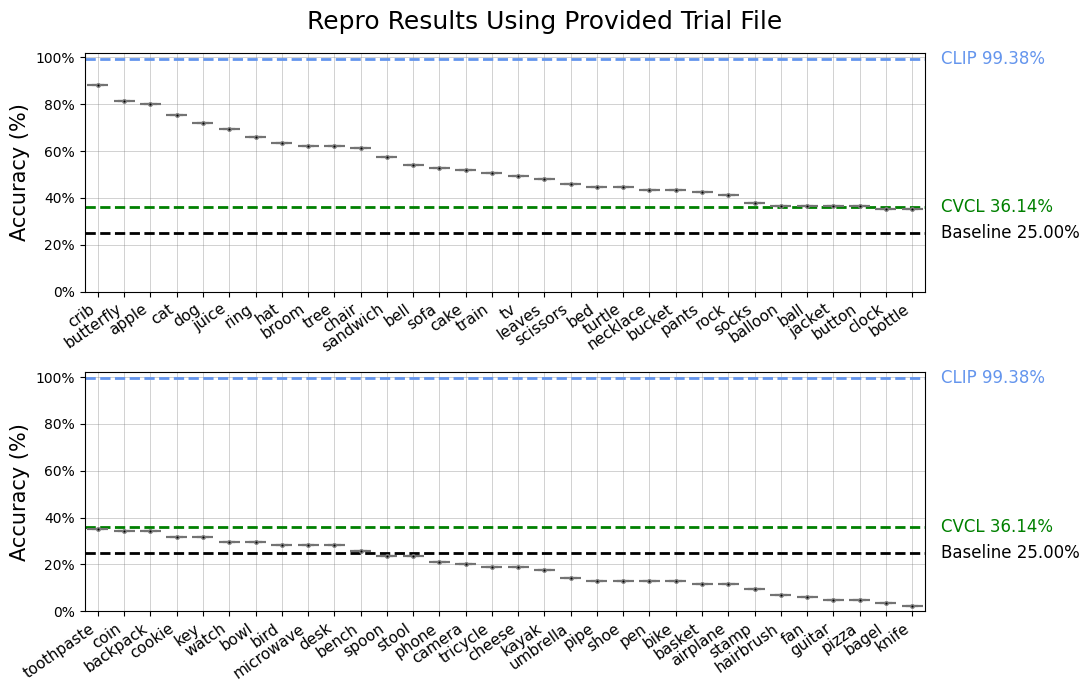

In [5]:
plt_class_acc(df_class, {k: np.mean(v) for k, v in overall_acc.items()}, len(df_class['Category'].unique()) // 2)

In [6]:
import pandas as pd

def get_sorted_categories(df):
    # Calculate median accuracy per category
    sorted_categories = df.groupby('Category')['Accuracy'].mean().sort_values(ascending=False)
    return sorted_categories.index.tolist()
# sort categories
repro_order = get_sorted_categories(df_class)

files1 = glob.glob('/home/xke001/demo/zero-shot/results/trial_*_08-30_*.json')
df_class1, overall_acc1 = load_data(files) 
df_class1 = prepare_dataframe(df_class1)
repro_order1 = get_sorted_categories(df_class1)

with open('publised_seed0_order.txt', 'r') as file:
    pub_order_seed0 = [line.strip() for line in file.readlines()]

with open('publised_order.txt', 'r') as file:
    pub_order = [line.strip() for line in file.readlines()]

Kendall's tau: 0.8263888888888888 p-value: 4.812423289474532e-22


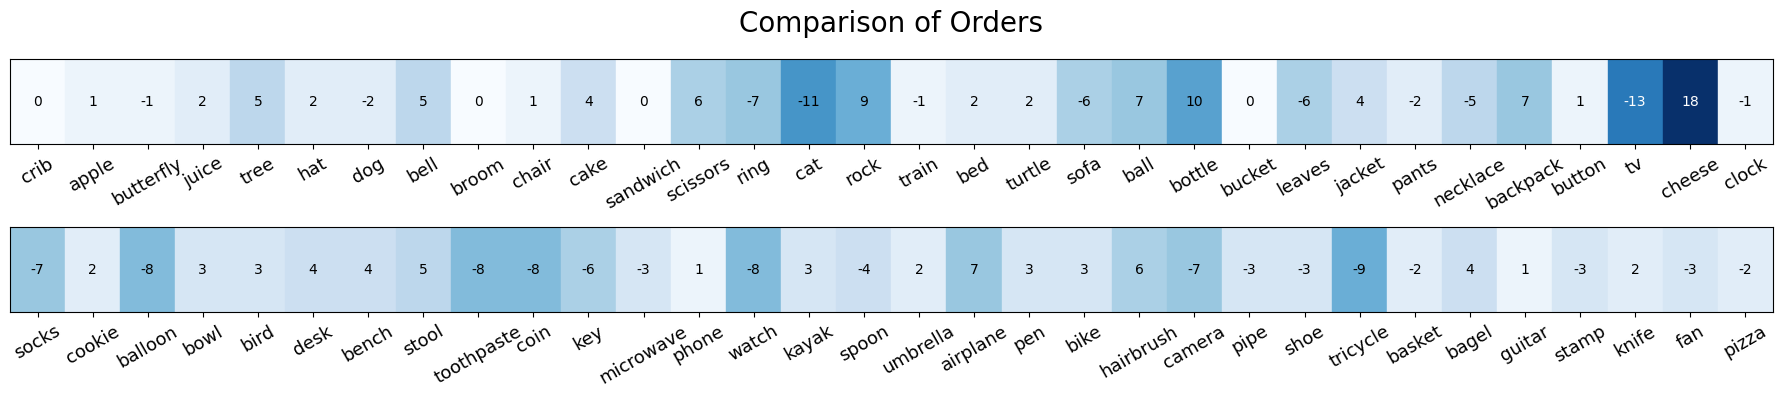

In [8]:
from scipy.stats import kendalltau

pub_order = pub_order_seed0
repro_order = repro_order1
index_map_pub = {item: rank for rank, item in enumerate(pub_order)}
index_map_hm = {item: rank for rank, item in enumerate(repro_order)}

rank_pub = [index_map_pub[item] for item in pub_order]
rank_hm = [index_map_hm[item] for item in pub_order]
tau, p_value_tau = kendalltau(rank_pub, rank_hm)
print("Kendall's tau:", tau, "p-value:", p_value_tau)


# calculate the difference between the two orders
differences = np.array([index_map_hm[item] - index_map_pub[item] for item in pub_order])

abs_diff = np.abs(differences)
# seperate plot in 2 parts
mid_point = len(pub_order) // 2

# 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4))  
fig.suptitle('Comparison of Orders', fontsize=20)

# color heatmap
cmap = plt.get_cmap('Blues')
norm = plt.Normalize(vmin=min(abs_diff), vmax=max(abs_diff))

# first part
for i, value in enumerate(abs_diff[:mid_point]):
    color = cmap(norm(value))
    square = plt.Rectangle((i, 0), 1, 1, color=color)
    ax1.add_patch(square)
    # display the actual difference value as text
    text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
    ax1.text(i + 0.5, 0.5, differences[i], ha='center', va='center', color=text_color, fontsize=10)

ax1.set_xlim(0, mid_point)
ax1.set_ylim(0, 1)
ax1.set_xticks(np.arange(0.5, mid_point + 0.5, 1))
ax1.set_xticklabels(pub_order[:mid_point], rotation=30, fontsize=13)
ax1.set_yticks([])

# second part
for i, value in enumerate(abs_diff[mid_point:]):
    color = cmap(norm(value))
    square = plt.Rectangle((i, 0), 1, 1, color=color)
    ax2.add_patch(square)
    # display the actual difference value as text
    text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
    ax2.text(i + 0.5, 0.5, differences[mid_point + i], ha='center', va='center', color=text_color, fontsize=10)

ax2.set_xlim(0, len(abs_diff) - mid_point)
ax2.set_ylim(0, 1)
ax2.set_xticks(np.arange(0.5, len(abs_diff) - mid_point + 0.5, 1))
ax2.set_xticklabels(pub_order[mid_point:], rotation=30, fontsize=13)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

### Fig.3.B Generalization Example Scores
Run following cells, they are doing:
1. Get trials containing example images.
2. Perform zero-shot evaluation on the example images.
3. Average the accuracy of the example images.(each img has 5 trials)

In [45]:
import json
# Get example img trials
seeds = [39, 40, 41, 42, 43]

def get_gen_trials(seed):
    images_txt_path = 'datasets/trials/gen_example.txt' 
    json_file_path = f'datasets/trials/object_5_3_{seed}.json'
    output_json_path = f'datasets/trials/gen_example_{seed}.json'

    with open(images_txt_path, 'r') as file:
        images = [line.strip() for line in file]

    with open(json_file_path, 'r') as file:
        data = json.load(file)

    filtered_data = []
    image_counters = {}
    category_counter = 1  

    for image_path in images:
        if image_path not in image_counters: 
            image_counters[image_path] = category_counter
            category_counter += 1 

        for item in data:
            if item["target_img_filename"] == image_path:
                new_item = item.copy()
                category_prefix = new_item["target_category"].rstrip('0123456789') 
                new_item["target_category"] = f"{category_prefix}{image_counters[image_path]}"
                filtered_data.append(new_item)

    with open(output_json_path, 'w') as file:
        json.dump(filtered_data, file, indent=4)
    
    return output_json_path

In [46]:
# run zs prediction on filtered json
from torch.utils.data import DataLoader
import torch
from data_utils import get_model, get_dataset
from utils import set_seed
from models.zs_trial_predic import ZSTrialClassifier

def main_zs(seed, json_path):
    set_seed(seed)
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    trial_path = json_path
        
    model_name = 'cvcl_res'
    model, transform = get_model(model_name, device)    
    data = get_dataset(dataset_name='object-trial', transform=transform, trials_file=trial_path)
    dataloader = DataLoader(data, batch_size=64, shuffle=False, num_workers=4)

    classifier = ZSTrialClassifier(model_name, model, device)

    acc, cls_acc = classifier.predict(dataloader=dataloader)

    # results = save_trial_results(args_dict=None, accuracy=acc, cls_accuracy=cls_acc)
    
    return cls_acc  

In [47]:
from collections import defaultdict
# loop all seeds
all_class_accuracies = defaultdict(list)
for seed in seeds:
    json_path = get_gen_trials(seed)
    cls_acc = main_zs(seed, json_path)


    for class_name, accuracy in cls_acc.items():
        all_class_accuracies[class_name].append(accuracy)

avg_class_acc = {class_name: sum(acc_list) / len(acc_list) 
                            for class_name, acc_list in all_class_accuracies.items()}

Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:16<00:00,  8.42s/it]


Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:13<00:00,  6.98s/it]


Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:12<00:00,  6.02s/it]


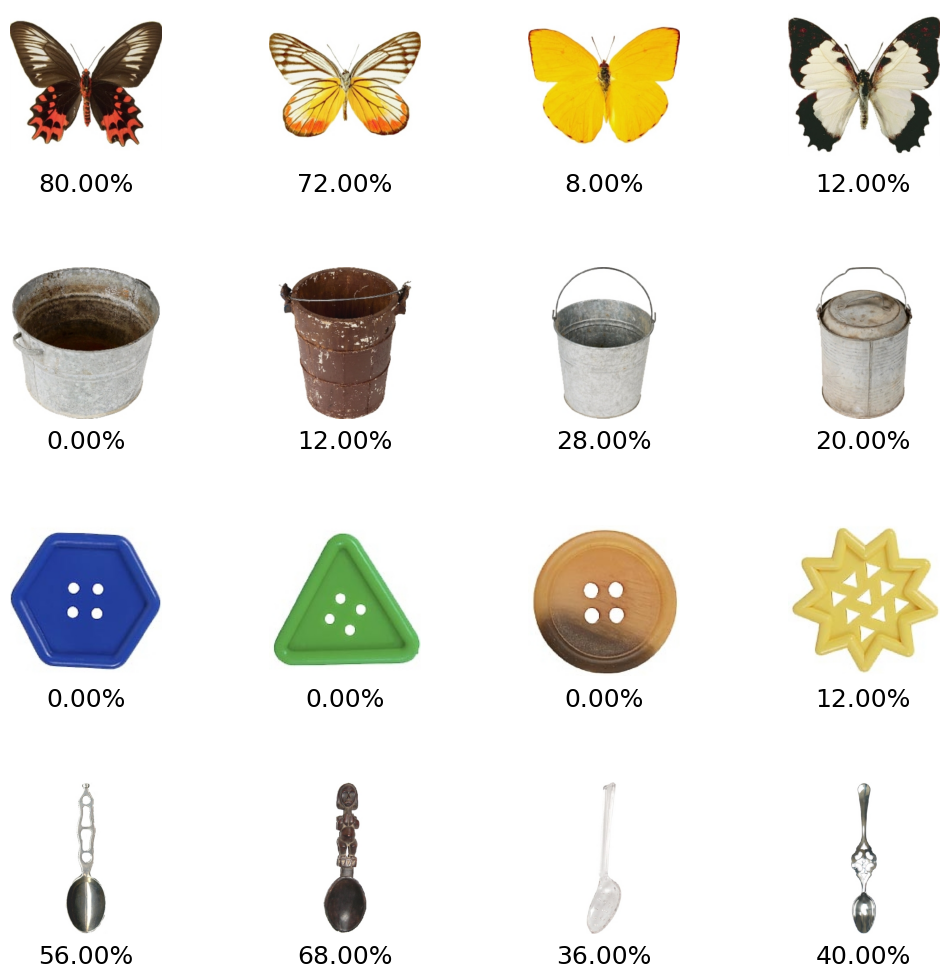

In [51]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# get scores avg 5 trials
# load image 
with open(f'datasets/trials/gen_example_{seeds[0]}.json', 'r') as file:  
    image_data = json.load(file)
    image_filenames = {entry['target_category']: entry['target_img_filename'] for entry in image_data}

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, (class_name, avg_accuracy) in enumerate(avg_class_acc.items()):
    img_path = image_filenames[class_name]
    if not img_path.startswith('/'):  
        img_path = f'datasets/trials/{img_path}'  
    img = plt.imread(img_path)  
    
    axes[i].imshow(img, extent=[0.3, 0.7, 0.3, 0.7])
    # axes[i].set_title(f'{avg_accuracy * 100:.2f}%', fontsize=18)
    axes[i].axis('off')
    axes[i].text(0.5, -0.2, f'{avg_accuracy * 100:.2f}%', fontsize=18, ha='center', transform=axes[i].transAxes)

    # rect = Rectangle((0, 0), 1, 1, transform=axes[i].transAxes,
    #                  linewidth=2, edgecolor='black', facecolor='none')
    # axes[i].add_patch(rect)

plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.show()